In [111]:
import pandas as pd
import numpy as np
import os
import json
import glob
import sqlite3

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression 

In [2]:
with open('../parameters.json') as json_data:
    params = json.load(json_data)
    
    DATA_DIR = params['DIRECTORIES']['DATA_DIR']
    TMP_DIR = params['DIRECTORIES']['TMP_DIR']
    PRICE_FILE = params['FILES']['PRICE_FILE']
    STATION_FILE =params['FILES']['STATION_FILE']
    SERVICE_FILE =params['FILES']['SERVICE_FILE']
    GAS_DB = os.path.join(DATA_DIR, params['DATABASE']['GAS_DB'])

In [4]:
dfall = pd.read_pickle(os.path.join(DATA_DIR,PRICE_FILE))
dfservices = pd.read_pickle(os.path.join(DATA_DIR, SERVICE_FILE))
dfstations = pd.read_pickle(os.path.join(DATA_DIR, STATION_FILE))

In [7]:
dfall['date_releve'] = pd.to_datetime(dfall.date_releve)

### Calcul de l'indice de prix hebdomadaire 

In [20]:
moyenne_hebdo_df = (dfall
 .dropna(subset=['date_releve'])
 .groupby(['libelle_carburant', pd.Grouper(key='date_releve', freq='1W-MON')])
 .agg({'prix': np.mean})
                   .reset_index()
                  )

In [34]:
model_df = (dfall
 .dropna(subset=['date_releve'])
 .groupby(['id_station', 'libelle_carburant', pd.Grouper(key='date_releve', freq='1W-MON')])
 .agg({'prix': np.mean})
              .reset_index()
              .merge(moyenne_hebdo_df, how='inner', on=['libelle_carburant', 'date_releve'], suffixes= ('','_moyen'))
.assign(indice = lambda df: df.prix / df.prix_moyen)
             )

### Construction du vecteur de services

In [44]:
vectorize = CountVectorizer(tokenizer=lambda x: x.split(','), lowercase=False)

<12391x25 sparse matrix of type '<class 'numpy.int64'>'
	with 75115 stored elements in Compressed Sparse Row format>

In [52]:
matrice_services_df = pd.SparseDataFrame(vectorize.fit_transform(dfservices.services.fillna('Rien')),
                  dfservices.id_station,
                  vectorize.get_feature_names(),
                  default_fill_value=0
                  ).reset_index()

(model_df
 .merge(matrice_services_df, how='outer', on=['id_station'],  indicator=True)
 ['_merge']
 .value_counts())

In [127]:
model_services_df = model_df.merge(matrice_services_df, how='inner', on=['id_station'])
model_services_df['Rural'] = np.where(model_service_df.type_station == 'R', 1, 0)

NameError: name 'model_service_df' is not defined

In [66]:
lr = LinearRegression()

In [68]:
set(matrice_services_df.columns)-{'id_station'}

{'Aire de camping-cars',
 'Automate CB',
 'Baie de service auto',
 'Bar',
 'Boutique alimentaire',
 'Boutique non alimentaire',
 'Carburant qualité supérieure',
 'Douches',
 'Espace bébé / change',
 'GPL',
 'Lavage haute-pression',
 'Lavage multi-programmes',
 'Laverie',
 'Location de véhicule',
 'Piste poids lourds',
 'Relais colis',
 'Restauration sur place',
 'Restauration à emporter',
 'Rien',
 'Station de gonflage',
 'Station de lavage',
 'Toilettes publiques',
 'Vente de fioul domestique',
 'Vente de gaz domestique',
 'Vente de pétrole lampant'}

In [114]:
lr.fit(X=model_services_df[list(set(matrice_services_df.columns)-{'id_station'})],
                                y=model_services_df.indice)                                    

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [115]:
lr.coef_

array([-0.00807226, -0.00047572, -0.00360002, -0.00748809,  0.01838106,
        0.00573528, -0.0002079 ,  0.00500321,  0.01417165, -0.01879372,
       -0.00086467,  0.01834778, -0.0130757 , -0.00135688, -0.00375147,
       -0.00731001, -0.01496684, -0.0079994 ,  0.00127529,  0.00243954,
        0.04518087,  0.00700189, -0.00761309, -0.01345772,  0.00945038])

In [121]:
model_services_df.Rien.sum()

416518

In [87]:
resultats = pd.DataFrame([(f,c) for f, c in zip(list(set(matrice_services_df.columns)-{'id_station'}), lr.coef_)],
                        columns=['Service', 'Coefficient']).sort_values('Coefficient', ascending=False)

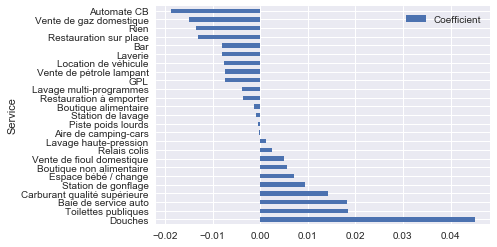

In [103]:
resultats.set_index('Service').plot(kind='barh')

In [122]:
import statsmodels.api as sm

X2 = sm.add_constant(model_services_df[list(set(matrice_services_df.columns)-{'id_station'})])
est = sm.OLS(model_services_df.indice, X2)
est2 = est.fit()
print(est2.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


                            OLS Regression Results                            
Dep. Variable:                 indice   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                 6.735e+04
Date:                Fri, 02 Feb 2018   Prob (F-statistic):               0.00
Time:                        16:30:39   Log-Likelihood:             5.9142e+06
No. Observations:             3220941   AIC:                        -1.183e+07
Df Residuals:                 3220915   BIC:                        -1.183e+07
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [ ]:
liste_varaibles = list(set(matrice_services_df.columns)-{'id_station'} + {'Rural'})

### Modélisation (Random Regressor)

In [116]:
rf = RandomForestRegressor()

In [117]:
rf.fit(X=model_services_df[list(set(matrice_services_df.columns)-{'id_station'})], y=model_services_df.indice)     

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [118]:
rf.coef_

AttributeError: 'RandomForestRegressor' object has no attribute 'coef_'

In [119]:
resultats_rf = pd.DataFrame([(f,c) for f, c in zip(list(set(matrice_services_df.columns)-{'id_station'}), rf.coef_)],
                        columns=['Service', 'Coefficient']).sort_values('Coefficient', ascending=False)

AttributeError: 'RandomForestRegressor' object has no attribute 'coef_'